# Sub-Clusters....

In [37]:
import jax
import jax.numpy as jnp
from dataclasses import dataclass
from functools import partial

In [38]:
@partial(jax.tree_util.register_dataclass,
         data_fields=('alpha', 'sigma', 'K', 'z', 'mu', 'pi', 'mu_sub', 'pi_sub', 'z_sub'),
         meta_fields = ())
@dataclass
class Latent:
    alpha: float
    sigma: float
    K: int
    pi: jax.Array
    mu: jax.Array
    z: jax.Array
    pi_sub: jax.Array
    mu_sub: jax.Array
    z_sub: jax.Array

def init_latent(key, alpha: float, sigma: float, num_data_points: int, dimension: int, K: int, K_max: int):
    if K > K_max:
        raise Exception()
    
    key, *subkeys = jax.random.split(key, 7)

    pi = jax.random.dirichlet(subkeys[0], alpha* jnp.ones(K+1))
    pi = jnp.concat([pi, jnp.zeros(K_max-K)])
    mu = jax.random.normal(subkeys[1], shape=(K_max, dimension))
    z = jax.random.categorical(subkeys[2], jnp.ones(K), shape=(num_data_points,))

    pi_sub = jax.random.dirichlet(subkeys[3], jnp.ones(2)*alpha, shape=(K_max,))
    mu_sub = jax.random.normal(subkeys[4], shape=(2, K_max, dimension))
    z_sub = jax.random.categorical(subkeys[5], jnp.array([0.5, 0.5]), shape=(num_data_points,))
    return Latent(alpha, sigma, K, pi, mu, z, pi_sub, mu_sub, z_sub)


In [97]:
def gibbs_pi(key, data, latent: Latent, K: int):
    counts = jnp.bincount(latent.z, length=K)
    concentrations = jnp.concat([counts, latent.alpha * jnp.ones(1)])
    pi = jax.random.dirichlet(key, concentrations)

    # this is a hack to avoid nans with jax.random.dirichlet
    pi = jnp.where(pi > 0, pi, 1e-4)
    pi = pi / jnp.sum(pi)

    pi = jnp.concat([pi, jnp.zeros(latent.pi.shape[0] - K-1)])

    return Latent(latent.alpha, latent.sigma, latent.K, pi, latent.mu, latent.z, latent.pi_sub, latent.mu_sub, latent.z_sub)

def gibbs_mu(key, data_nL, latent: Latent):
    K_max = latent.mu.shape[0]
    sigma_hyper = 1.0
    counts = jnp.bincount(latent.z, length=K_max)
    sigma_sq_posterior = 1/(1 + counts / sigma_hyper**2)
    x_sum = jax.ops.segment_sum(data_nL, latent.z, K_max)
    mu_posterior = sigma_sq_posterior.reshape(-1,1) * x_sum / sigma_hyper**2 
    noise = jax.random.normal(key, (K_max,latent.mu.shape[1]))
    mu_new =  noise * jnp.sqrt(sigma_sq_posterior).reshape(-1,1) + mu_posterior
    return Latent(
        alpha=latent.alpha, 
        sigma=latent.sigma, 
        K=latent.K,
        pi=latent.pi,
        mu=mu_new, 
        z=latent.z, 
        pi_sub=latent.pi_sub,
        mu_sub=latent.mu_sub,
        z_sub=latent.z_sub,
        )

def gibbs_z(key, data_nL, latent: Latent):
    log_pi = jnp.log(latent.pi)[:-1]
    log_pi = jnp.where(jnp.arange(log_pi.shape[0]) < latent.K, log_pi, -jnp.inf)
    def pdf(x, mu, log_pi):
        z_scores = (x - mu) / latent.sigma
        log_p = log_pi + jnp.sum(jax.scipy.stats.norm.logpdf(z_scores))
        return log_p

    log_probs = jax.vmap(jax.vmap(pdf, in_axes=(None, 0, 0)), in_axes=(0, None, None))(data_nL, latent.mu, log_pi)
    z_new = jax.random.categorical(key, log_probs)
    return Latent(
        alpha=latent.alpha, 
        sigma=latent.sigma, 
        K=latent.K,
        pi=latent.pi,
        mu=latent.mu,
        z=z_new,
        pi_sub=latent.pi_sub,
        mu_sub=latent.mu_sub,
        z_sub=latent.z_sub,
        )

def gibbs_pi_sub(key, data_nL, latent: Latent):
    K_max = latent.pi.shape[0]-1
    idx = latent.z + latent.z_sub * K_max
    counts = jax.ops.segment_sum(jnp.ones(latent.z.shape), idx, 2*K_max)
    counts = counts.reshape(2,K_max).T
    alpha = counts + latent.alpha/2
    pi_sub = jax.random.dirichlet(key, alpha=alpha)
    return Latent(
        alpha=latent.alpha, 
        sigma=latent.sigma, 
        K=latent.K,
        pi=latent.pi,
        mu=latent.mu,
        z=latent.z,
        pi_sub=pi_sub,
        mu_sub=latent.mu_sub,
        z_sub=latent.z_sub,
        )


def gibbs_mu_sub(key, data_nL, latent: Latent):
    K_max = latent.mu.shape[0]
    idx = latent.z + latent.z_sub * K_max
    counts = jax.ops.segment_sum(jnp.ones(latent.z.shape), idx, 2*K_max)
    sigma_hyper = 1.0
    sigma_sq_posterior = 1/(1 + counts / sigma_hyper**2)
    sigma_sq_posterior = sigma_sq_posterior.reshape(-1,1)

    x_sum = jax.ops.segment_sum(data_nL, idx, 2*K_max)
    mu_posterior = sigma_sq_posterior * x_sum / sigma_hyper**2 
    D = latent.mu.shape[1]
    mu_sub_new = jax.random.normal(key, (2*K_max,D)) *jnp.sqrt(sigma_sq_posterior) + mu_posterior
    mu_sub_new = mu_sub_new.reshape(2,K_max, D)
    return Latent(
        latent.alpha,
        latent.sigma,
        latent.K,
        latent.pi,
        latent.mu,
        latent.z,
        latent.pi_sub,
        mu_sub_new,
        latent.z_sub
    )

def gibbs_z_sub(key, data_nL, latent: Latent):
    log_pi_sub = jnp.log(latent.pi_sub)
    def log_pdf(x, z, mus, log_pis):
        mu = mus[z]
        log_pi = log_pis[z]
        z_scores = (x - mu) / (latent.sigma)
        log_p = log_pi + jnp.sum(jax.scipy.stats.norm.logpdf(z_scores))
        return log_p


    sub_func = jax.vmap(log_pdf, in_axes=(None, None, 0, 1))

    log_probs = jax.vmap(sub_func, in_axes=(0, 0, None, None))(data_nL, latent.z, latent.mu_sub, log_pi_sub)
    z_sub_new = jax.random.categorical(key, log_probs)

    return Latent(
        alpha=latent.alpha, 
        sigma=latent.sigma, 
        K=latent.K,
        pi=latent.pi,
        mu=latent.mu,
        z=latent.z,
        pi_sub=latent.pi_sub,
        mu_sub=latent.mu_sub,
        z_sub=z_sub_new,
        )

@partial(jax.jit, static_argnames=('K',))
def gibbs_sweep(key, data_nL, latent: Latent, K: int):
    key, *subkeys = jax.random.split(key, 7)
    latent = gibbs_pi(subkeys[0], data_nL, latent, K)
    latent = gibbs_pi_sub(subkeys[3], data_nL, latent)
    latent = gibbs_mu(subkeys[1], data_nL, latent)
    latent = gibbs_mu_sub(subkeys[4], data_nL, latent)
    latent = gibbs_z(subkeys[2], data_nL, latent)
    latent = gibbs_z_sub(subkeys[5], data_nL, latent)
    return latent


In [120]:
N = 50
D = 2
K = 4
K_max = 7
alpha = 2.0
sigma_obs = 1.00

key = jax.random.key(0)
key, subkey = jax.random.split(key)
mu_true = 2*jax.random.normal(subkey, (K, D))
z_true = jax.random.categorical(subkey, jnp.ones(K), shape=(N,))
data = jax.random.normal(key, (N, D)) * sigma_obs + mu_true[z_true]


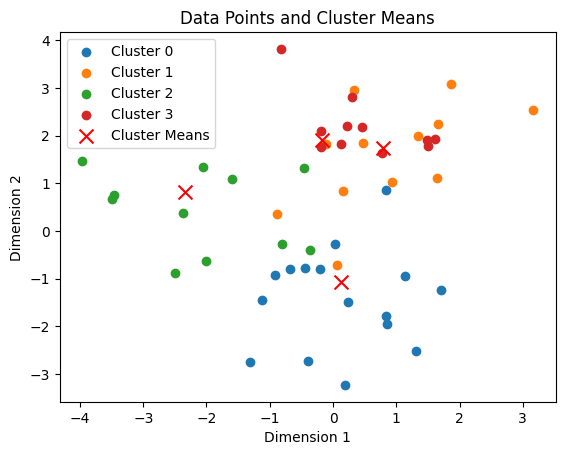

In [137]:
import matplotlib.pyplot as plt

# Define colors for clusters

# Plot the data points with inferred clusters
for k in range(K):
    plt.scatter(data[z_true == k, 0], data[z_true == k, 1], label=f'Cluster {k}')

# Plot the inferred means
plt.scatter(mu_true[:K, 0], mu_true[:K, 1], color='red', marker='x', s=100, label='Cluster Means')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.title('Data Points and Cluster Means')
plt.show()

In [138]:
latent = init_latent(key, alpha, sigma_obs, N, D, K-1, K_max)
latent_history = [latent]
for i in range(10):
    key, subkey = jax.random.split(key)
    latent = gibbs_sweep(subkey, data, latent, K-1)
    latent_history.append(latent)

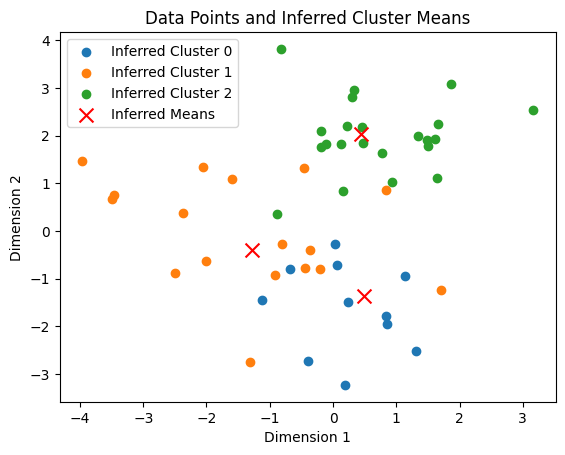

In [139]:
import matplotlib.pyplot as plt

# Define colors for clusters

# Plot the data points with inferred clusters
for k in range(K-1):
    plt.scatter(data[latent.z == k, 0], data[latent.z == k, 1], label=f'Inferred Cluster {k}')

# Plot the inferred means
plt.scatter(latent.mu[:K-1, 0], latent.mu[:K-1, 1], color='red', marker='x', s=100, label='Inferred Means')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.title('Data Points and Inferred Cluster Means')
plt.show()

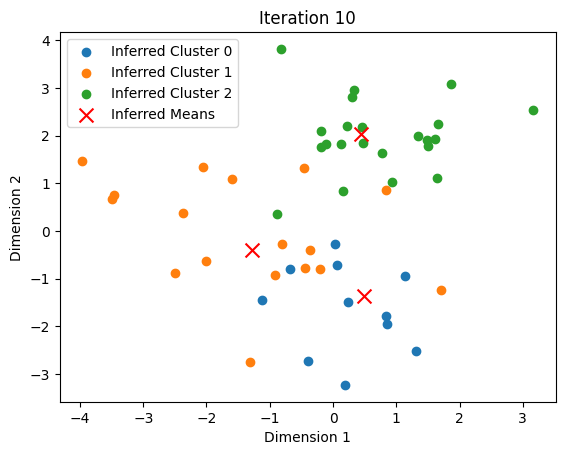

In [141]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()

def update(frame):
    ax.clear()
    latent = latent_history[frame]
    for k in range(K-1):
    # for k in range(K):
        ax.scatter(data[latent.z == k, 0], data[latent.z == k, 1], label=f'Inferred Cluster {k}')
    # ax.scatter(latent.mu[:K, 0], latent.mu[:K, 1], color='red', marker='x', s=100, label='Inferred Means')
    ax.scatter(latent.mu[:K-1, 0], latent.mu[:K-1, 1], color='red', marker='x', s=100, label='Inferred Means')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.legend()
    ax.set_title(f'Iteration {frame}')

ani = animation.FuncAnimation(fig, update, frames=len(latent_history), repeat=False)
ani.save('inferred_clusters_animation.mp4', writer='ffmpeg')
plt.show()

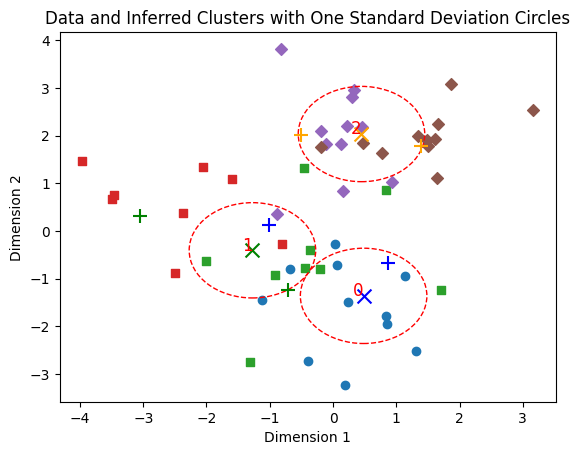

In [149]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define markers and colors
markers = ['o', 's', 'D', '^', 'v', '<', '>']
colors = ['blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
# Add index labels near the means
for k in range(K-1):
    plt.text(latent.mu[k, 0], latent.mu[k, 1], f'{k}', fontsize=12, color='red', ha='right')
    for j in range(2):
        idx = (latent.z == k) & (latent.z_sub == j)
        plt.scatter(data[idx, 0], data[idx, 1], label=f'Inferred Cluster {k}-{j}', marker=markers[k % len(markers)])

    # Plot the inferred means
    plt.scatter(latent.mu[k, 0], latent.mu[k, 1], color=colors[k], marker='x', s=100, label=f'Inferred Mean {k}')
    
    # Plot the circle indicating one standard deviation away
    circle = patches.Circle((latent.mu[k, 0], latent.mu[k, 1]), radius=latent.sigma, fill=False, edgecolor='red', linestyle='--')
    plt.gca().add_patch(circle)

    # Plot the inferred means for subclusters
    for j in range(2):
        plt.scatter(latent.mu_sub[j, k, 0], latent.mu_sub[j, k, 1], color=colors[k], marker='+', s=100, label=f'Inferred Subcluster Mean {k}-{j}')


plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
# plt.legend()
plt.title('Data and Inferred Clusters with One Standard Deviation Circles')
plt.show()

In [150]:
def marginal_loglikelihood_sufficient_statistics(
        x_mean:jax.Array, 
        x_sum_sq:jax.Array, 
        N:int, 
        sigma_sq: float, 
        mu_0: float, 
        sigma_sq_0: float
    ):
    c = 0.5*jnp.log(sigma_sq) - 0.5 * (N*jnp.log(2 * jnp.pi * sigma_sq) + jnp.log(N*sigma_sq_0 + sigma_sq))

    A = -x_sum_sq / (2 * sigma_sq) - mu_0**2 / 2 / sigma_sq_0

    denom = 2*(N * sigma_sq_0 + sigma_sq)
    numer = sigma_sq_0 * N**2 * x_mean**2 / sigma_sq + sigma_sq * mu_0**2 / sigma_sq_0 + 2 * N * x_mean * mu_0
    B = denom / numer
    return c + A + B

def marginal_loglikelihood(x, sigma_sq, mu_0, sigma_sq_0):
    x_mean = jnp.mean(x, axis=0)
    x_sum_sq = jnp.sum(x**2, axis=0)

    N = x.shape[0]
    return marginal_loglikelihood_sufficient_statistics(x_mean, x_sum_sq, N, sigma_sq, mu_0, sigma_sq_0)


In [151]:
def mh_split(key, data, latent):
    K_max = latent.pi.shape[0]-1
    idx = latent.z + latent.z_sub * K_max

    sub_counts = jax.ops.segment_sum(jnp.ones(latent.z.shape), idx, 2*K_max)
    counts = jnp.bincount(latent.z, length=K_max)

    x_sum_sub = jax.ops.segment_sum(data, idx, 2*K_max)
    x_mean_sub = x_sum_sub / sub_counts.reshape(-1, 1)
    x_sum_sq_sub = jax.ops.segment_sum(data**2, idx, 2*K_max)

    x_sum = jax.ops.segment_sum(data, latent.z, K_max)
    x_sum_sq = jax.ops.segment_sum(data**2, latent.z, K_max)
    x_mean = x_sum / counts.reshape(-1, 1)

    log_p_sub = jax.vmap(
        marginal_loglikelihood_sufficient_statistics, 
        in_axes=(0, 0, 0, None, None, None))(x_mean_sub, x_sum_sq_sub, sub_counts, latent.sigma, 0.0, 1.0)
        
    log_p_sub = jnp.where(jnp.isnan(log_p_sub), 0.0, log_p_sub)
    log_p_sub = jnp.sum(log_p_sub, axis=1)
    log_p_sub = jnp.sum(log_p_sub.reshape(2, K_max), axis=0)

    log_p = jax.vmap(
        marginal_loglikelihood_sufficient_statistics, 
        in_axes=(0, 0, 0, None, None, None))(x_mean, x_sum_sq, counts, latent.sigma, 0.0, 1.0)
    log_p = jnp.where(jnp.isnan(log_p), 0.0, log_p)
    log_p = jnp.sum(log_p, axis=1)

    sub_counts = sub_counts.reshape(2, K_max).T
    ratio = jnp.log(latent.alpha) + jnp.sum(jax.scipy.special.gammaln(sub_counts), axis=1) - jax.scipy.special.gammaln(counts)
    ratio = ratio + log_p_sub
    ratio = ratio - log_p
    ratio = jnp.where(jnp.isnan(ratio), -jnp.inf, ratio)
    ratio = jnp.where(ratio > 0, 0, ratio)
    ratio = jnp.where(ratio == jnp.inf, 0, ratio)
    ratio = jnp.exp(ratio)
    accepts = jax.random.uniform(key, (ratio.shape[0],)) < ratio
    return accepts
    

In [ ]:
def normalize_latent(latent, K):
    z = latent.z
    unique_vals = jnp.unique(z, size=K, fill_value=1000000000)
    # print(unique_vals)

    # latent.mu[]
    z_new = jnp.searchsorted(unique_vals, z, method='sort')

    pi = latent.pi
    return Latent(
        latent.alpha,
        latent.sigma,
        latent.K,
        latent.pi,
        latent.mu,
        z_new,
        latent.pi_sub,
        latent.mu_sub,
        latent.z_sub
    )

normalize_latent(latent, 3)

[0 1 2]


Latent(alpha=Array(2., dtype=float32, weak_type=True), sigma=Array(1., dtype=float32, weak_type=True), K=Array(3, dtype=int32, weak_type=True), pi=Array([0.18095681, 0.37822875, 0.41257277, 0.0282417 , 0.        ,
       0.        , 0.        , 0.        ], dtype=float32), mu=Array([[ 0.48372495, -1.3636018 ],
       [-1.2735299 , -0.40752804],
       [ 0.4500947 ,  2.032709  ],
       [ 1.6798486 , -0.25979078],
       [ 0.96907634, -0.7511777 ],
       [-0.5653657 , -0.5354302 ],
       [-0.9029019 ,  0.92294025]], dtype=float32), z=Array([2, 1, 0, 0, 1, 2, 0, 1, 1, 0, 1, 1, 2, 2, 1, 1, 0, 2, 1, 2, 0, 2,
       2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 0, 1, 2, 1, 2, 0, 1, 2, 2, 0, 2, 1,
       1, 2, 2, 2, 0, 0], dtype=int32), pi_sub=Array([[0.8971081 , 0.1028919 ],
       [0.796864  , 0.203136  ],
       [0.5158339 , 0.48416606],
       [0.8963228 , 0.10367718],
       [0.7453937 , 0.25460625],
       [0.1640812 , 0.8359188 ],
       [0.9295871 , 0.07041288]], dtype=float32), mu_sub=Array([[[ 0

In [209]:
jnp.unique(jnp.array([5,3,1,2]), fill_value=100)

Array([1, 2, 3, 5], dtype=int32)